In [29]:
import matplotlib

import matplotlib.pyplot as plt

import numpy as np

import os

import torch

from scipy.io import loadmat

from tqdm.notebook import tqdm

In [7]:
%matplotlib inline

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

In [33]:
methods = [ 'superpoint', 'lf-net', 'd2-net', 'd2-net-ms', 'd2-net-trained', 'd2-net-trained-ms']
names = ['Hes. Aff. + Root-SIFT', 'HAN + HN++', 'DELF', 'DELF New', 'SuperPoint', 'LF-Net', 'D2-Net', 'D2-Net MS', 'D2-Net Trained', 'D2-Net Trained MS']
colors = ['black', 'orange', 'red', 'red', 'blue', 'brown', 'purple', 'green', 'purple', 'green']
linestyles = ['-', '-', '-', '--', '-', '-', '-', '-', '--', '--']

In [35]:
# Change here if you want to use top K or all features.
# top_k = 2000
top_k = None 
n_i = 52
n_v = 56
dataset_path = 'hpatches-sequences-release'

In [24]:
lim = [1, 15]
rng = np.arange(lim[0], lim[1] + 1)

In [10]:
def mnn_matcher(descriptors_a, descriptors_b):
    device = descriptors_a.device
    sim = descriptors_a @ descriptors_b.t()
    nn12 = torch.max(sim, dim=1)[1]
    nn21 = torch.max(sim, dim=0)[1]
    ids1 = torch.arange(0, sim.shape[0], device=device)
    mask = (ids1 == nn21[nn12])
    matches = torch.stack([ids1[mask], nn12[mask]])
    return matches.t().data.cpu().numpy()


In [31]:
def benchmark_features(read_feats):
    seq_names = sorted(os.listdir(dataset_path))

    n_feats = []
    n_matches = []
    seq_type = []
    i_err = {thr: 0 for thr in rng}
    v_err = {thr: 0 for thr in rng}

    for seq_idx, seq_name in enumerate(seq_names):
        keypoints_a, descriptors_a = read_feats(seq_name, 1)
        n_feats.append(keypoints_a.shape[0])

        for im_idx in range(2, 7):
            keypoints_b, descriptors_b = read_feats(seq_name, im_idx)
            n_feats.append(keypoints_b.shape[0])

            matches = mnn_matcher(
                torch.from_numpy(descriptors_a).to(device=device), 
                torch.from_numpy(descriptors_b).to(device=device)
            )
            
            homography = np.loadtxt(os.path.join(dataset_path, seq_name, "H_1_" + str(im_idx)))
            
            pos_a = keypoints_a[matches[:, 0], : 2] 
            pos_a_h = np.concatenate([pos_a, np.ones([matches.shape[0], 1])], axis=1)
            pos_b_proj_h = np.transpose(np.dot(homography, np.transpose(pos_a_h)))
            pos_b_proj = pos_b_proj_h[:, : 2] / pos_b_proj_h[:, 2 :]

            pos_b = keypoints_b[matches[:, 1], : 2]

            dist = np.sqrt(np.sum((pos_b - pos_b_proj) ** 2, axis=1))

            n_matches.append(matches.shape[0])
            seq_type.append(seq_name[0])
            
            if dist.shape[0] == 0:
                dist = np.array([float("inf")])
            
            for thr in rng:
                if seq_name[0] == 'i':
                    i_err[thr] += np.mean(dist <= thr)
                else:
                    v_err[thr] += np.mean(dist <= thr)
    
    seq_type = np.array(seq_type)
    n_feats = np.array(n_feats)
    n_matches = np.array(n_matches)
    
    return i_err, v_err, [seq_type, n_feats, n_matches]

In [11]:
def summary(stats):
    seq_type, n_feats, n_matches = stats
    print('# Features: {:f} - [{:d}, {:d}]'.format(np.mean(n_feats), np.min(n_feats), np.max(n_feats)))
    print('# Matches: Overall {:f}, Illumination {:f}, Viewpoint {:f}'.format(
        np.sum(n_matches) / ((n_i + n_v) * 5), 
        np.sum(n_matches[seq_type == 'i']) / (n_i * 5), 
        np.sum(n_matches[seq_type == 'v']) / (n_v * 5))
    )

In [12]:
def generate_read_function(method, extension='ppm'):
    def read_function(seq_name, im_idx):
        aux = np.load(os.path.join(dataset_path, seq_name, '%d.%s.%s' % (im_idx, extension, method)))
        if top_k is None:
            return aux['keypoints'], aux['descriptors']
        else:
            assert('scores' in aux)
            ids = np.argsort(aux['scores'])[-top_k :]
            return aux['keypoints'][ids, :], aux['descriptors'][ids, :]
    return read_function

In [17]:
def sift_to_rootsift(descriptors):
    return np.sqrt(descriptors / np.expand_dims(np.sum(np.abs(descriptors), axis=1), axis=1) + 1e-16)
def parse_mat(mat):
    keypoints = mat['keypoints'][:, : 2]
    raw_descriptors = mat['descriptors']
    l2_norm_descriptors = raw_descriptors / np.expand_dims(np.sum(raw_descriptors ** 2, axis=1), axis=1)
    descriptors = sift_to_rootsift(l2_norm_descriptors)
    if top_k is None:
        return keypoints, descriptors
    else:
        assert('scores' in mat)
        ids = np.argsort(mat['scores'][0])[-top_k :]
        return keypoints[ids, :], descriptors[ids, :]

In [18]:
if top_k is None:
    cache_dir = 'cache'
else:
    cache_dir = 'cache-top'
if not os.path.isdir(cache_dir):
    os.mkdir(cache_dir)

In [14]:
errors = {}

In [39]:
import os

for method in methods:
    output_file = os.path.join(cache_dir, method + '.npy')
    print(method)
    if method == 'hesaff':
        read_function = lambda seq_name, im_idx: parse_mat(loadmat(os.path.join(dataset_path, seq_name, '%d.ppm.hesaff' % im_idx), appendmat=False))
    else:
        if not os.path.exists(os.path.join(cache_dir, method)):
            os.makedirs(os.path.join(cache_dir, method))
        read_function = generate_read_function(method, extension='png')
    if os.path.exists(output_file):
        print('Loading precomputed errors...')
        errors[method] = np.load(output_file, allow_pickle=True)
    else:
        errors[method] = benchmark_features(read_function)
        np.save(output_file, errors[method])
    summary(errors[method][-1])

superpoint
Loading precomputed errors...
# Features: 1562.611111 - [90, 6422]
# Matches: Overall 883.440741, Illumination 667.830769, Viewpoint 1083.650000
lf-net
Loading precomputed errors...
# Features: 500.000000 - [500, 500]
# Matches: Overall 177.475926, Illumination 183.073077, Viewpoint 172.278571
d2-net
Loading precomputed errors...
# Features: 2994.067901 - [641, 9337]
# Matches: Overall 1182.574074, Illumination 964.588462, Viewpoint 1384.989286
d2-net-ms
Loading precomputed errors...
# Features: 4928.163580 - [1009, 15230]
# Matches: Overall 1698.377778, Illumination 1384.215385, Viewpoint 1990.100000
d2-net-trained
Loading precomputed errors...
# Features: 5965.117284 - [1309, 18974]
# Matches: Overall 2495.900000, Illumination 2033.250000, Viewpoint 2925.503571
d2-net-trained-ms
Loading precomputed errors...
# Features: 8254.473765 - [1797, 26880]
# Matches: Overall 2831.638889, Illumination 2313.957692, Viewpoint 3312.342857


In [58]:
(errors["superpoint"][2][1])

array([ 448,  448,  424,  265,  261,  279,  656,  821,  866, 1376, 1397,
        666,  323,  372,  407,  421,  443,  440,  600,  558,  623,  625,
        606,  595, 1132, 1056, 1277, 1267, 1241, 1300, 1880, 1886, 1923,
       1848, 2130, 2574, 2141, 2438, 2026, 2134, 2046, 2231,  942,  885,
        770,  705,  714,  812, 1093, 1175, 1172, 1152, 1090,  984, 2057,
       1771, 1824, 1885, 1661, 1827, 1814, 1885, 1645, 1694, 1684, 1879,
        921,  900,  888,  876,  841,  731,  570,  576,  569,  544,  395,
        348,  353,  298,  253,  189,  202,  156,  427,  428,  427,  459,
        448,  452,  505,  533,  514,  528,  469,  518,  876,  843,  880,
        880,  823,  769,  885,  838, 1029,  994,  911,  821, 1958, 2100,
       2009, 2064, 2076, 2136,  469,  521,  673,  373,  355,  687,  383,
        421,  409,  419,  420,  403, 1677, 1704, 1676, 1678, 1638, 1586,
        800, 1000, 1139, 1225, 1257, 1230,  634,  713,  601,  780,  625,
        606,  774,  778,  782,  819,  691,  641, 25

In [63]:
a, b, c = (errors["d2-net"][-1])
print(c)

[ 727  405  268  261  282 1472 1298  853  868 1224  426  421  379  370
  370  585  609  640  688  612 1144 1071 1085  782  767 2345 1999 1965
 1397  373 1817 2285 1521 2345 1875  554  589  512  444  459 1086 1082
 1046  982  897 1599 1950 2287 2347 1542 2159  873  886  899 1425  752
  691  611  600  506  561  485  296  244  248  469  368  320  229  215
  612  614  617  579  589  579  590  538  548  573  724  759  686  699
  677  806 1016 1049 1036  930 1841 1611 1423 1410 1347  448  401  310
  290  375  743  497  359  448  340 2584 2300 2071 1889 1683 1152 1066
  985  877  778  458  501  334  390  473  532  458  565  530  582 2700
 2385 1971 1369 1861  814  661  467  730  645 1269 1028  800  571  974
  947 1005 1078  970  913 2468 2746 1206 2566 2307  689  515  384  360
  358 2631 2495 2207 2102 2884  559  550  453  394  445  809  731  666
  647  593  704  553  577  622  617  355  227  229  284  278  435  446
  348  277  220 1603 1937 1909 1549 1702 1596 1287 1031 1330 1176 1252
 1247 

Plotting

In [40]:
plt_lim = [1, 10]
plt_rng = np.arange(plt_lim[0], plt_lim[1] + 1)

Exception ignored in: <function tqdm.__del__ at 0x7fb671c3fe20>
Traceback (most recent call last):
  File "/Users/pahl/opt/anaconda3/envs/DHBW/lib/python3.10/site-packages/tqdm/std.py", line 1145, in __del__
    self.close()
  File "/Users/pahl/opt/anaconda3/envs/DHBW/lib/python3.10/site-packages/tqdm/notebook.py", line 283, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x7fb671c3fe20>
Traceback (most recent call last):
  File "/Users/pahl/opt/anaconda3/envs/DHBW/lib/python3.10/site-packages/tqdm/std.py", line 1145, in __del__
    self.close()
  File "/Users/pahl/opt/anaconda3/envs/DHBW/lib/python3.10/site-packages/tqdm/notebook.py", line 283, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


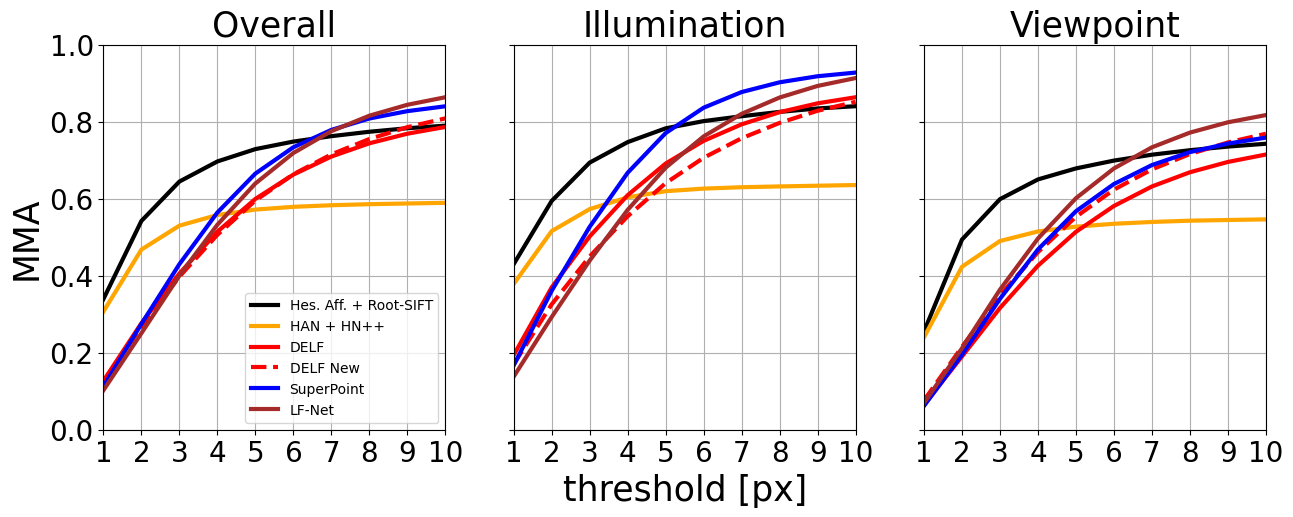

In [41]:
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=25)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
for method, name, color, ls in zip(methods, names, colors, linestyles):
    i_err, v_err, _ = errors[method]
    plt.plot(plt_rng, [(i_err[thr] + v_err[thr]) / ((n_i + n_v) * 5) for thr in plt_rng], color=color, ls=ls, linewidth=3, label=name)
plt.title('Overall')
plt.xlim(plt_lim)
plt.xticks(plt_rng)
plt.ylabel('MMA')
plt.ylim([0, 1])
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()

plt.subplot(1, 3, 2)
for method, name, color, ls in zip(methods, names, colors, linestyles):
    i_err, v_err, _ = errors[method]
    plt.plot(plt_rng, [i_err[thr] / (n_i * 5) for thr in plt_rng], color=color, ls=ls, linewidth=3, label=name)
plt.title('Illumination')
plt.xlabel('threshold [px]')
plt.xlim(plt_lim)
plt.xticks(plt_rng)
plt.ylim([0, 1])
plt.gca().axes.set_yticklabels([])
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)

plt.subplot(1, 3, 3)
for method, name, color, ls in zip(methods, names, colors, linestyles):
    i_err, v_err, _ = errors[method]
    plt.plot(plt_rng, [v_err[thr] / (n_v * 5) for thr in plt_rng], color=color, ls=ls, linewidth=3, label=name)
plt.title('Viewpoint')
plt.xlim(plt_lim)
plt.xticks(plt_rng)
plt.ylim([0, 1])
plt.gca().axes.set_yticklabels([])
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)